#### **7PAM2015-0509-2024 -- Research Methods in Data Science**
##### Image Segmentaion on COCO-2017 Dataset with Specific Classes - Cake, Car, Person and Dog. 
---
**Mohit Agarwal (Student ID-22031257)**

This notebook performs Exploratory Data Analysis on COCO-2017 dataset.


##### COCO-2017 Dataset
- COCO (Common Objects in Context) is a large-scale object detection, segmentation, and captioning dataset. 
- It contains 330K images, with 80 object categories and 91 stuff categories
    - For this assginment 300 images on training and validation set each and 30 on test without annotation
    - The target class will be limited to "car", "person", "dog", and "cake".
- The dataset features complex everyday scenes containing common objects in their natural context
- COCO-2017 is widely used for training and evaluating models for object detection, segmentation and captioning tasks
- The dataset provides instance segmentation, object detection and keypoint detection annotations

In [1]:
# importing required libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from pycocotools.coco import COCO
import skimage.io as io
from collections import Counter, defaultdict
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Changing the default styles and palettes

In [2]:
# setting style
sns.set_style("darkgrid")
# setting context
sns.set_context("paper")
# setting palette
sns.set_palette("deep", color_codes=True)

Setting Path for the COCO Dataset

In [3]:
# setting root directory for the dataset
ROOT_DATASET_DIR = r"D:\MScDataScience\9.Research_Methods\Assignment\Assignment1\RM_Segmentation_Assignment_dataset"

In [4]:
# setting the path for the training data
train_data_path = os.path.join(ROOT_DATASET_DIR, "train-300")
# setting the path for the training annotations
train_annotation_file = os.path.join(train_data_path, "labels.json")

In [5]:
# setting the path for the validation data
val_data_path = os.path.join(ROOT_DATASET_DIR, "validation-300")
# setting the path for the validation annotations
val_annotation_file = os.path.join(val_data_path, "labels.json")

Setting Path to Save Images

In [6]:
# setting the path to save the images
save_images_path = r"D:\MScDataScience\9.Research_Methods\Assignment\Assignment1\Images"

### Function to Fliter the Images Based on Target Classes

In [ ]:
# defining a function to get image IDs for target classes
def get_image_id(coco, target_classes, plot=False, plot_name="train", return_traget_id=False):
    """
    This function retrieves an image ID from the COCO dataset that 
    contains at least one of the specified target classes.

    Args:
       coco: COCO API object.
       target_classes: list of target class names.
       plot: boolean, if True, plots the number of images per category.
       plot_name: string, name of the plot to be saved.
       return_traget_id: boolean, if True, returns the category IDs dictionary.

    Returns:
       image_ids: list of unique image IDs.
       target_category_dict: dictionary of target category IDs and names.
    """

    # getting category IDs for the target classes
    target_category_ids = coco.getCatIds(catNms=target_classes)
    # getting category names for the target classes
    target_category_names = coco.loadCats(target_category_ids)
    # disctionary to store number of images per category
    category_count = {}
    # getting image IDs for the target classes
    image_ids = []
    for i, id in enumerate(target_category_ids):
        print(
            f"Category ID: {id}, Category Name: {target_category_names[i]['name']}")
        # getting image IDs for the category
        ids = coco.getImgIds(catIds=id)
        print(f"Number of Images: {len(ids)}")
        # updating the category count
        category_count[target_category_names[i]['name']] = len(ids)
        image_ids.extend(ids)

    # checking for the plot flag
    if plot:
        # plotting the number of images per category
        plt.figure()
        ax = sns.barplot(x=list(category_count.keys()),
                         y=list(category_count.values()),
                         hue=target_classes)
        # adding bar labels
        for container in ax.containers:
            ax.bar_label(container)
        plt.title(f"Number of Images per Category- {plot_name.capitalize()}")
        plt.xlabel("Category")
        plt.ylabel("Number of Images")
        plt.tight_layout()
        plt.savefig(os.path.join(save_images_path,
                                 f"{plot_name}_images_per_category.png"))
        plt.show()

    # checking for return_traget_id flag
    if return_traget_id:
        # disctionary to store category IDs and names
        target_category_dict = {}
        # updating the target category dictionary
        target_category_dict.update(
            {id: target_category_names[i]["name"] for i, id in enumerate(target_category_ids)})

        # returning the target category dictionary and image IDs
        return list(set(image_ids)), target_category_dict

    # removing duplicates by converting to a set and then back to a list
    # returning unique image IDs
    return list(set(image_ids))

### Function to Display some of the Images with Mask, Bounding Box and Labels

In [85]:
# defining a fuction to display images with mask, bounding box and labels in a grid
def display_instances(image_IDs, target_dict, coco, title, image_loc, figsize=(20, 10)):
    """
    Display image instances with masks, bounding boxes and class labels
in a grid

    Args:
            image_IDs: list of image ids
            target_dict: dict. of traget classes with names and id
            coco: COCO API object.
            title: Figure title
            image_local: image location to be read from
            figsize: the size of the image
    """

    # setting a particular color for each class
    colors = plt.cm.rainbow(np.linspace(0, 1, len(target_dict)))
    color_dict = {id: colors[i] for i, id in enumerate(target_dict.keys())}

    # creating a figure
    fig, axs = plt.subplots(nrows=len(image_IDs), ncols=3, figsize=figsize)

    # for each image, display image, mask only, and with mask, bbox and labels
    for i, img_id in enumerate(image_IDs):
        # getting image info
        img_info = coco.loadImgs(img_id)[0]
        # getting image path
        img_path = os.path.join(image_loc, "data",
                                img_info["file_name"])
        # getting image
        im = io.imread(img_path)
        # getting annotations for the image
        annIds = coco.getAnnIds(
            imgIds=img_id, catIds=target_dict.keys(), iscrowd=None)
        anns = coco.loadAnns(annIds)

        # addding original image to column 1
        axs[i, 0].imshow(im)
        # setting title to sub-images
        axs[i, 0].set_title("Original Image")
        axs[i, 1].set_title("Instance Segmentation Mask")
        axs[i, 2].set_title("Mask Overlay with b-box & Labels")

        # addding original image to column 2
        axs[i, 2].imshow(im)

        # for each ann adding mask, bounding box and labels
        for j, ann in enumerate(anns):
            # getting the color per annotation
            color = color_dict[ann["category_id"]]
            # converting mask to binary
            mask = coco.annToMask(ann)

            # creating mask for column 2
            color_mask_only = np.zeros((mask.shape[0], mask.shape[1], 4))
            color_mask_only[:, :, 0] = mask * color[0]  # red color
            color_mask_only[:, :, 1] = mask * color[1]  # green color
            color_mask_only[:, :, 2] = mask * color[2]  # blue color
            color_mask_only[:, :, 3] = mask * 0.75  # mask transparency
            # adding mask to column 2
            axs[i, 1].imshow(color_mask_only)
            axs[i, 1].set_facecolor("grey")

            # for column 3
            # adding bounding box to column 3
            bbox = ann["bbox"]
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                     linewidth=2, edgecolor=color, facecolor="none")
            axs[i, 2].add_patch(rect)
            # adding labels to column 3
            axs[i, 2].text(bbox[0], bbox[1]-5, target_dict[ann["category_id"]],
                           color="blue", fontsize=12, fontweight="bold",
                           bbox=dict(facecolor=color, alpha=0.5,
                                     boxstyle="round", pad=0.2))
            # creating mask for column 3
            color_mask_bbox = np.zeros((mask.shape[0], mask.shape[1], 4))
            color_mask_bbox[:, :, 0] = color[0]  # red color
            color_mask_bbox[:, :, 1] = color[1]  # green color
            color_mask_bbox[:, :, 2] = color[2]  # blue color
            color_mask_bbox[:, :, 3] = mask * 0.75  # mask transparency
            # adding mask to column 3
            axs[i, 2].imshow(color_mask_bbox)

            # removing all axis
            axs[i, 0].axis("off")
            axs[i, 1].axis("off")
            axs[i, 2].axis("off")
            # tight layout
            plt.tight_layout()

    # adding super title to the image
    fig.suptitle(f"Some Examples of {title.capitalize()} Set",
                 fontsize=16, fontweight="bold")
    plt.tight_layout()
    fig.savefig(os.path.join(save_images_path,
                             f"grid_display{title}_examples.png"),
                bbox_inches="tight")
    fig.show()

### Function to Analysis the Filtered Images

In [ ]:
# function image analysis on the filtered images
def image_analysis(coco, image_ids, plot_title):
    """
    This function performs image analysis on the 
    target classes in the COCO dataset and plots the distribution 
    graphs of the images.

    Args:
            coco: COCO API object.
            image_ids: list of image IDs.
    Returns:
            image_stats: image stats
    """

    # getting all the images from the image IDs
    images = coco.loadImgs(image_ids)

    # dictionary to store image stats
    image_stats = {}
    # list for heights and widths of the images
    heights = []
    widths = []
    # list for the areas & aspect ratios of the images
    areas = []
    aspect_ratios = []

    # extracting height and width of the images
    for img in images:
        # getting image height and width
        heights.append(img["height"])
        widths.append(img["width"])
        # calculating the area of the image
        areas.append(img["height"] * img["width"])
        # calculating the aspect ratios of the image
        aspect_ratios.append(img["height"] / img["width"])

    # adding to height and widths to the dictionary
    image_stats["heights"] = heights
    image_stats["widths"] = widths
    # adding the areas and aspect ratios to the dictionary
    image_stats["areas"] = areas
    image_stats["aspect_ratios"] = aspect_ratios
    # adding stats to the image stats dictionary
    image_stats["stats"] = {
        "heights": {
            "mean": np.mean(heights),
            "median": np.median(heights),
            "std": np.std(heights),
            "min": np.min(heights),
            "max": np.max(heights),
        },
        "widths": {
            "mean": np.mean(widths),
            "median": np.median(widths),
            "std": np.std(widths),
            "min": np.min(widths),
            "max": np.max(widths),
        },
        "areas": {
            "mean": np.mean(areas),
            "median": np.median(areas),
            "std": np.std(areas),
            "min": np.min(areas),
            "max": np.max(areas),
        },
        "aspect_ratios": {
            "mean": np.mean(aspect_ratios),
            "median": np.median(aspect_ratios),
            "std": np.std(aspect_ratios),
            "min": np.min(aspect_ratios),
            "max": np.max(aspect_ratios),
        },
    }

    # plotting the heights, widths, areas and aspect ratios of the images
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    # plotting the heights
    axs[0, 0].hist(heights, alpha=0.5, label="Height",
                   density=True, color="red")
    axs[0, 0].set_title("Height", fontweight="bold")
    axs[0, 0].set_xlabel("Heigh (pixels)")
    axs[0, 0].legend()
    # plotting the widths
    axs[0, 1].hist(widths, alpha=0.5, label="Width",
                   density=True, color="blue")
    axs[0, 1].set_title("Width", fontweight="bold")
    axs[0, 1].set_xlabel("Width (pixels)")
    axs[0, 1].legend()
    # plotting the areas
    axs[1, 0].hist(areas, alpha=0.5, label="Area", density=True, color="green")
    axs[1, 0].set_title("Area", fontweight="bold")
    axs[1, 0].set_xlabel("Area (Height x width)")
    axs[1, 0].legend()
    # plotting the aspect ratios
    axs[1, 1].hist(aspect_ratios, alpha=0.5,
                   label="Aspect Ratio", density=True, color="orange")
    axs[1, 1].set_title("Aspect Ratio", fontweight="bold")
    axs[1, 1].set_xlabel("Aspect Ratio (Height / Width)")
    axs[1, 1].legend()
    # adding super title
    fig.suptitle(f"{plot_title.capitalize()} Image Analysis",
                 fontsize=16, fontweight="bold")
    plt.tight_layout()
    # saving the plot
    plt.savefig(os.path.join(save_images_path,
                             f"{plot_title}_image_analysis.png"))
    plt.show()

    return image_stats

### Function to Plot Number of Images per Height x width

In [ ]:
# function to plot the number of images per height and width
def plot_img_per_height_width(image_stats, plot_title):
    """
    This function plots the number of images per height x width
    for the target classes in the COCO dataset.

    Args:
            image_stats: dictionary containing stats
            plot_title: string, title of the plot.
    Return:
            hw_imgs_count: dictionary counter of images
    """

    # getting number of counts per hxw
    hw_imgs_count = Counter(zip(image_stats["heights"], image_stats["widths"]))
    # sorting the dictionary
    hw_imgs_count = dict(sorted(hw_imgs_count.items()))

    # plotting the heights and widths of the images
    plt.figure(figsize=(12, 8))
    sns.barplot(x=np.arange(len(hw_imgs_count)),
                y=hw_imgs_count.values(), color="blue")
    plt.title(f"Number of Images per Height x Width for {plot_title.capitalize()}",
              fontsize=12,
              fontweight="bold")
    plt.xticks(np.arange(len(hw_imgs_count)),
               hw_imgs_count.keys(), rotation=90)
    plt.xlabel("Height x Width")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.savefig(os.path.join(save_images_path,
                             f"{plot_title.capitalize()}_images_per_hw.png"))
    plt.show()

    # returing the count dict
    return hw_imgs_count

### Function to Analysis the Segmentation Based on the Target Classses

In [ ]:
# defining a function to handle segmentation analysis
def segmentation_analysis(coco, image_ids, cat_ids):
    """
    This function performs segmentation analysis on the
    target classes in the COCO dataset and plots the distribution
    graphs of the segmentation.

    Args:
                    coco: COCO API object.
                    image_ids: list of image IDs.
                    cat_ids: list of traget IDs.
    Returns:
                    result_anlysis: summary of the analysis
    """

    # getting all the images from the image IDs
    img_infos = coco.loadImgs(image_ids)

    # basic category stats
    category_stats = defaultdict(
        lambda: {"count": 0, "total_area": 0, "area": []})
    # supercategory stats
    supercategory_stats = defaultdict(lambda: {"count": 0, "total_area": 0})
    # bounding box stats
    bbox_stats = []
    # segmentation stats
    segmentation_stats = []
    # area distribution
    area_dist = []
    # storing all the annotations
    annotations = []

    # for each image, get the segmentation, area and bbox
    for img_info in img_infos:
        # getting image ID
        img_id = img_info["id"]
        # getting annotations for the image
        annIds = coco.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(annIds)
        # updating the annotations
        annotations.extend(anns)
        # for each annotation, get the segmentation, area and bbox
        for ann in anns:
            # getting segmentation
            segmentation = ann["segmentation"]
            # getting area
            area = ann["area"]
            # getting bounding box
            bbox = ann["bbox"]

            # updating category stats
            category_stats[ann["category_id"]]["count"] += 1
            category_stats[ann["category_id"]]["total_area"] += area
            category_stats[ann["category_id"]]["area"].append(area)

            # updating supercategory stats
            supercategory_stats[ann["supercategory"]]["count"] += 1
            supercategory_stats[ann["supercategory"]]["total_area"] += area

            # updating bounding box stats
            bbox_stats.append({
                "id": ann["id"],
                "width": bbox[2],
                "height": bbox[3],
                "aspect_ratio": bbox[3] / bbox[2],
                "bbox_area": bbox[2] * bbox[3],
                "seg_area": area,
                "area_ratio": area / (bbox[2] * bbox[3])
            })

            # updating segmentation stats
            segmentation_stats.append({
                "id": ann["id"],
                # number of polygons makes segmentation
                "num_polygons": len(segmentation),
                # number of points in each polygon
                "num_points": [len(poly) for poly in segmentation],
                "total_points": sum([len(poly) for poly in segmentation]),
                "avg_points_per_poly": np.mean([len(poly) for poly in segmentation]),
                "max_points_per_poly": max([len(poly) for poly in segmentation]),
                "min_points_per_poly": min([len(poly) for poly in segmentation]),
                "avg_points_per_poly_per_ann": np.mean([len(poly) for poly in segmentation])
            })

            # updating area distribution
            area_dist.append({
                "id": ann["id"],
                "area": area,
                "category_id": ann["category_id"],
                "supercategory": ann["supercategory"]
            })

        # storing the results
    results_anlysis = {
        "total_anns": annotations,
        "category_stats": dict(category_stats),
        "supercategory_stats": dict(supercategory_stats),
        "bbox_stats": pd.DataFrame(bbox_stats),
        "segmentation_stats": pd.DataFrame(segmentation_stats),
        "area_dist": pd.DataFrame(area_dist)
    }

    return results_anlysis

### Initialization of COCO API for training and validation datasets

In [11]:
# Initialising COCO API for instance annotations.
# for training data
train_coco = COCO(train_annotation_file)
# for validation data
val_coco = COCO(val_annotation_file)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


Setting Targets as Cake, Car, Dog and Person

In [12]:
# setting the target classes
target_classes = ["cake", "car", "dog", "person"]

### Counting the Number of Images per Folder - train, validation and test.

In [13]:
# counting the number of images in the training set
train_image_count = len(train_coco.getImgIds())
# counting the number of images in the validation set
val_image_count = len(val_coco.getImgIds())
# counting the number of images in the test set
test_image_count = len(os.listdir(os.path.join(ROOT_DATASET_DIR, "test-30")))
# Printing the Number of Images per Folder - train, validation and test.
print(f"Number of images in the validation set: {val_image_count}")
print(f"Number of images in the training set: {train_image_count}")
print(f"Number of images in the test set: {test_image_count}")

Number of images in the validation set: 300
Number of images in the training set: 300
Number of images in the test set: 30


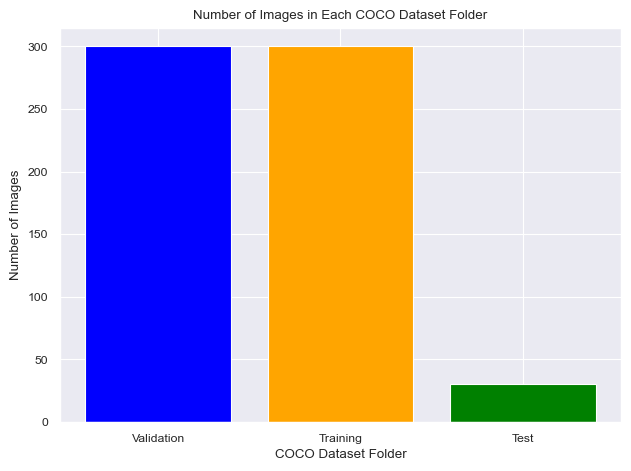

In [14]:
# plotting the number of images per folder
plt.figure()
plt.bar(["Validation", "Training", "Test"], [val_image_count,
                                             train_image_count, test_image_count], color=['blue', 'orange', 'green'])
plt.title("Number of Images in Each COCO Dataset Folder")
plt.xlabel("COCO Dataset Folder")
plt.ylabel("Number of Images")
plt.tight_layout()
# saving the plot
plt.savefig(os.path.join(save_images_path, "images_per_folder.png"))
plt.show()

The total number images per training and validation is 300 and 30 in testing. The images in training and validation floder are not filtered out meaning images may content classes outside the scoop of this assignment, we need to filters this images which only contents the target classes so the model learns the relevant information.

### Filtering Images According to Targets
Filtering images as per targets classes so the model can focus and learn from those images that have tragets in them rather than learning features that might affect the outcome of the model.

For Training

Category ID: 15, Category Name: cake
Number of Images: 1
Category ID: 16, Category Name: car
Number of Images: 283
Category ID: 25, Category Name: dog
Number of Images: 10
Category ID: 41, Category Name: person
Number of Images: 272


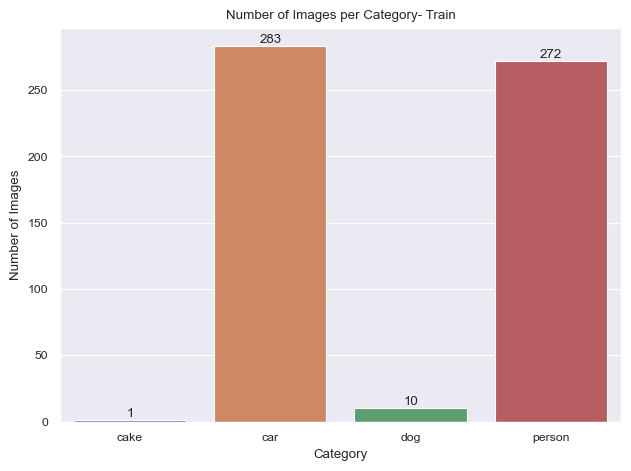

In [15]:
# getting image IDs for the target classes in the training set
train_image_ids, target_dict = get_image_id(train_coco, target_classes,
                                            plot=True, plot_name="train",
                                            return_traget_id=True)

For Validation

Category ID: 14, Category Name: cake
Number of Images: 4
Category ID: 15, Category Name: car
Number of Images: 236
Category ID: 24, Category Name: dog
Number of Images: 9
Category ID: 41, Category Name: person
Number of Images: 225


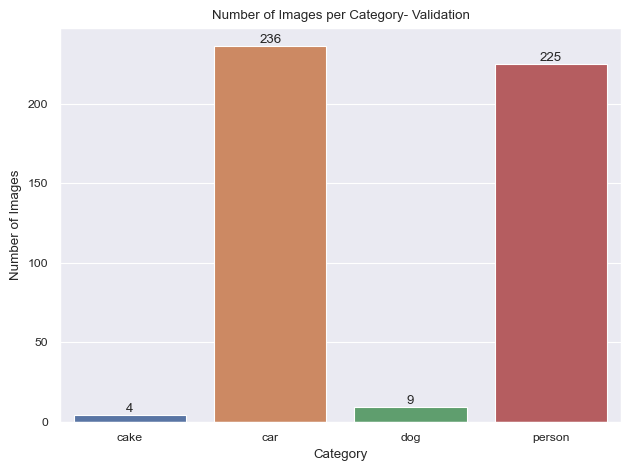

In [16]:
# getting image IDs for the target classes in the validation set
val_image_ids = get_image_id(val_coco, target_classes,
                             plot=True, plot_name="Validation",
                             return_traget_id=False)

The dataset has more number of car and persons on an image then cake and dog. The dataset highly imbalance, as the data is object inside the images the imbalance nature of the dataset cann't be resolved, even if we add more number images the imbalance will remain agian we are talking about objects inside the images, not images as a whole.

Images on Training and Valdiation after Target Filter

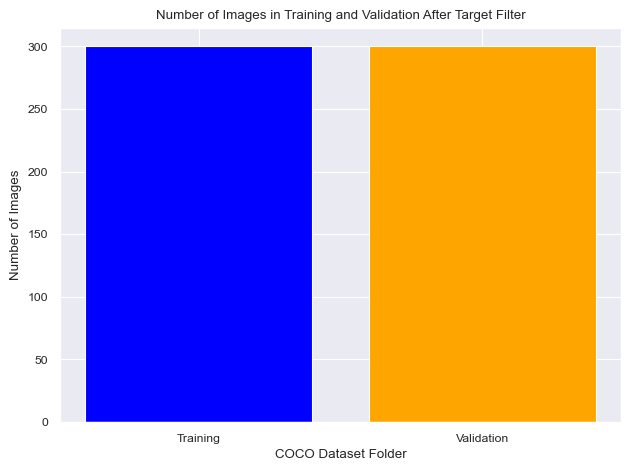

In [17]:
# plot images in training and validation set
plt.figure()
plt.bar(["Training", "Validation"], [len(train_image_ids),
                                     len(val_image_ids)], color=['blue', 'orange'])
plt.title("Number of Images in Training and Validation After Target Filter")
plt.xlabel("COCO Dataset Folder")
plt.ylabel("Number of Images")
plt.tight_layout()
# saving the plot
plt.savefig(os.path.join(save_images_path, "images_per_folder_filtered.png"))
plt.show()

The number of images for traning and validation data remained unchanged, i.e 300 per train and val. 

### Display Some Images from Training and Validation Set with Mask

For Training Set

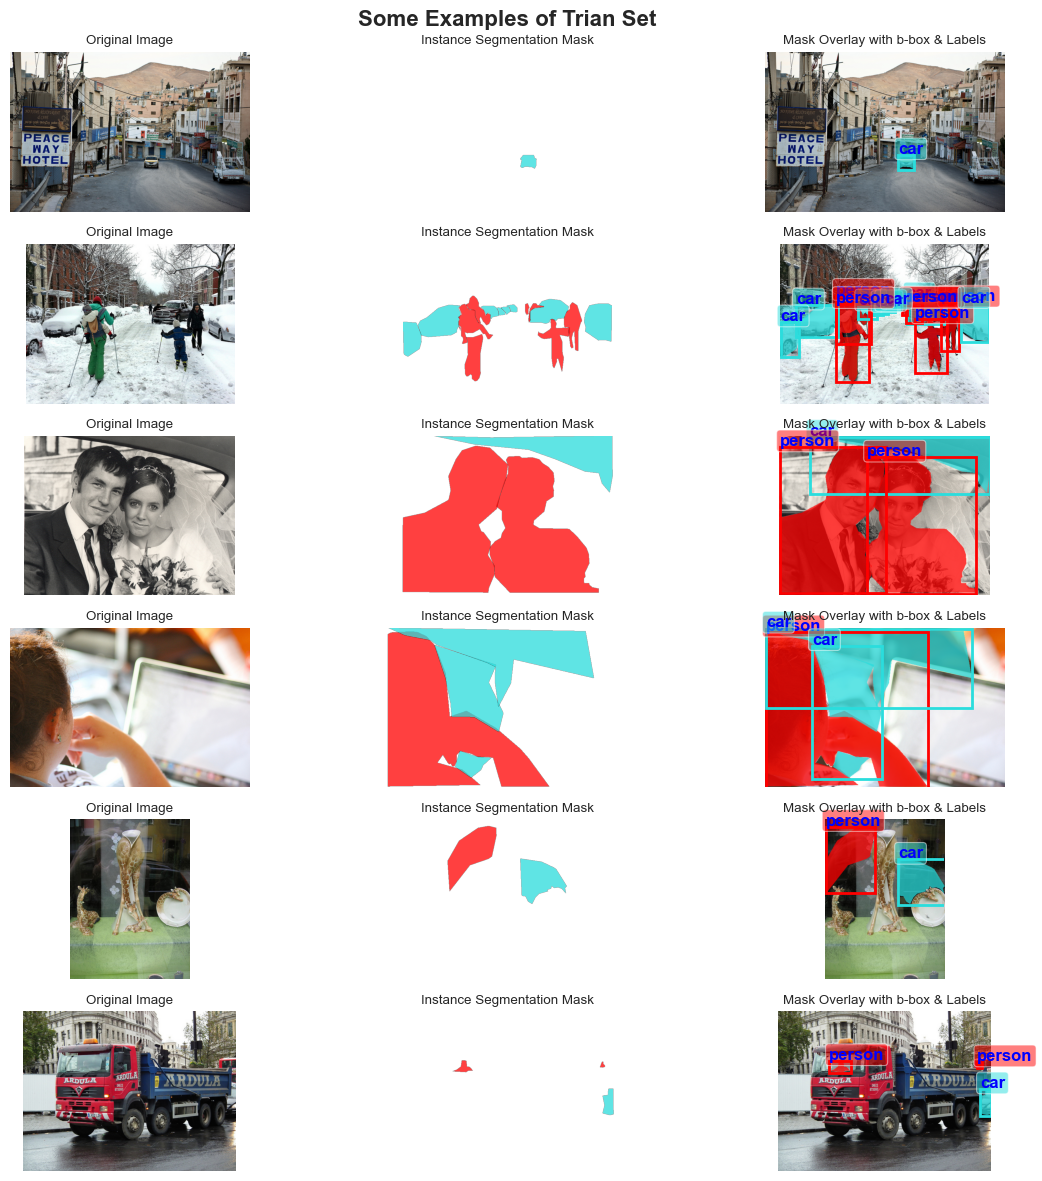

In [ ]:
# display few images with mask from training set
display_instances(random.sample(train_image_ids, 6),
                  target_dict, train_coco, title="trian",
                  image_loc=train_data_path, figsize=(25, 12))

For Validation Set

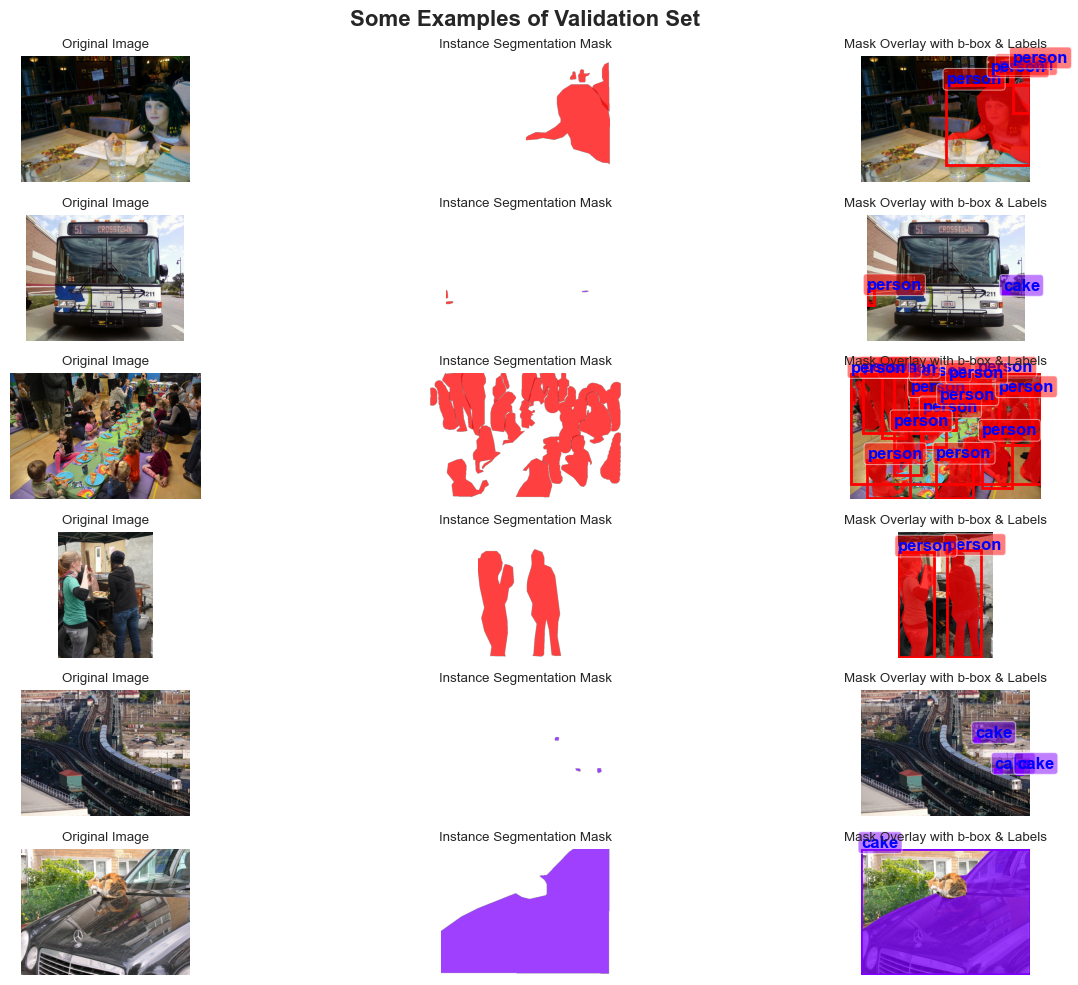

In [ ]:
# display few images with mask from training set
display_instances(random.sample(val_image_ids, 6),
                  target_dict, val_coco, title="validation",
                  image_loc=val_data_path)

The label data seems to in great detail, capturing the smallest objects or just the part of the object, which is good for deep learning model. From the above visualization it is proof that are more person and car objects than dogs or cake present in an image.

### Image Analysis on Training Dataset

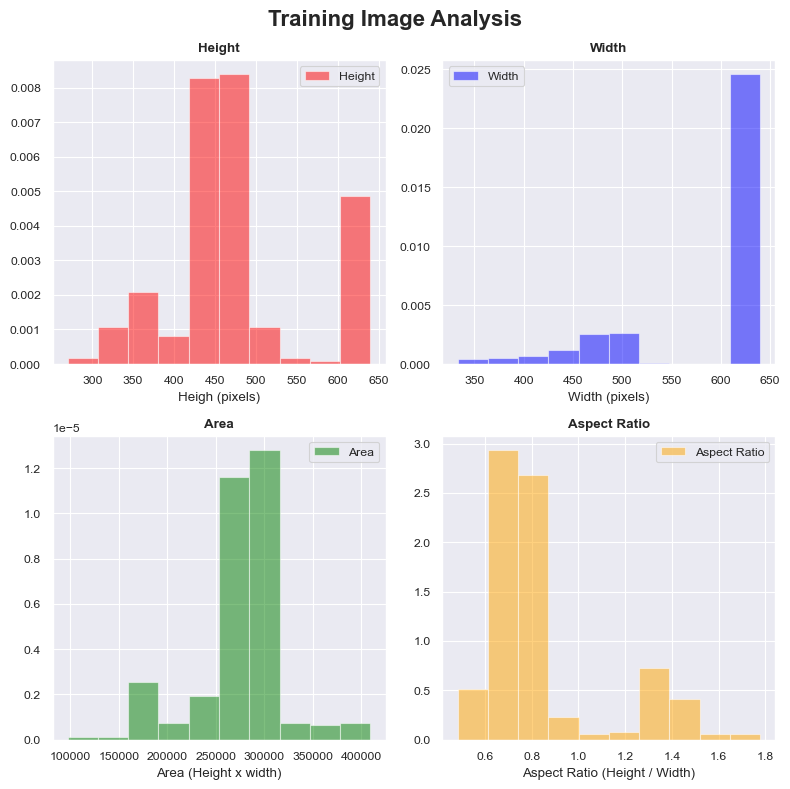

In [20]:
# train imae analysis
train_image_stats = image_analysis(train_coco, train_image_ids, "training")

**Insights:**
- **Hieght Distribution (Top Left):** High concentration around pixel 450, with majority of the images' height between 400 and 500 pixels. A secondary pick at 600 pixel can be seen, indicating two common image train format.
- **Width Distribution (Top Right):** The distribution is right skewed, with higher cluster at 600 pixel, meaning the train images are wider than they are tell.
- **Area Distribution (Bottom Left):** The distribution is roughly normal, with strong concentration of images on 250000-300000 area which corresponds to images with 500x600 pixel or similar dimensions. 
- **Aspect-Ratio Distribution (Bottom Right):** As the number values present at the 0.6-0.9 is higher, it can be confirmed the images are wider.

The training images also smaller number of images with different sizes but for the most part higher number of images has height of 450 and width of 650.

Plotting the Number of Images per Size Present in the Training Set

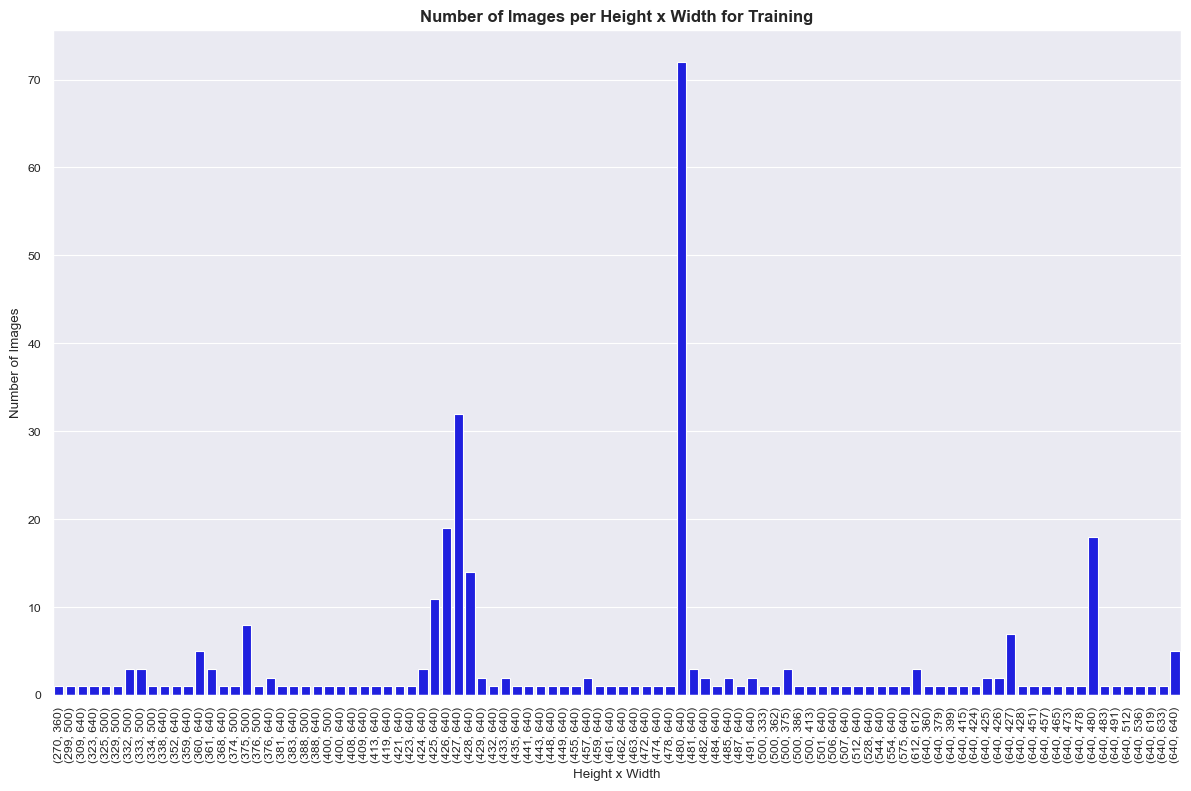

In [21]:
# number of images per hxw
train_hw_img_count = plot_img_per_height_width(train_image_stats, "training")

As we can see the number of images with height and width of around 450 and 650 respectively are higher.

In [22]:
# looking at the stats of the training images
pd.DataFrame.from_dict(train_image_stats["stats"])

,heights,widths,areas,aspect_ratios
mean,475.396667,595.296667,279786.706667,0.829246
median,480.000000,640.000000,273920.000000,0.750000
std,88.316586,80.590500,46495.158257,0.274412
min,270.000000,333.000000,97200.000000,0.482812
max,640.000000,640.000000,409600.000000,1.777778


**Insights:**
- The majory of images have a height of around 480 and a width of around 600. 
- Images are wider than they are tall, hitting 640 pixels mark.
- In height the mean and median are very close indicating a normal distribution.
- Aspect Ratio's mean is higher than median, indicating a right skewed, which can be seen in the right bottom of "Image Analysis Training" graph. Some images are square.

### Image Analysis on Validation Dataset

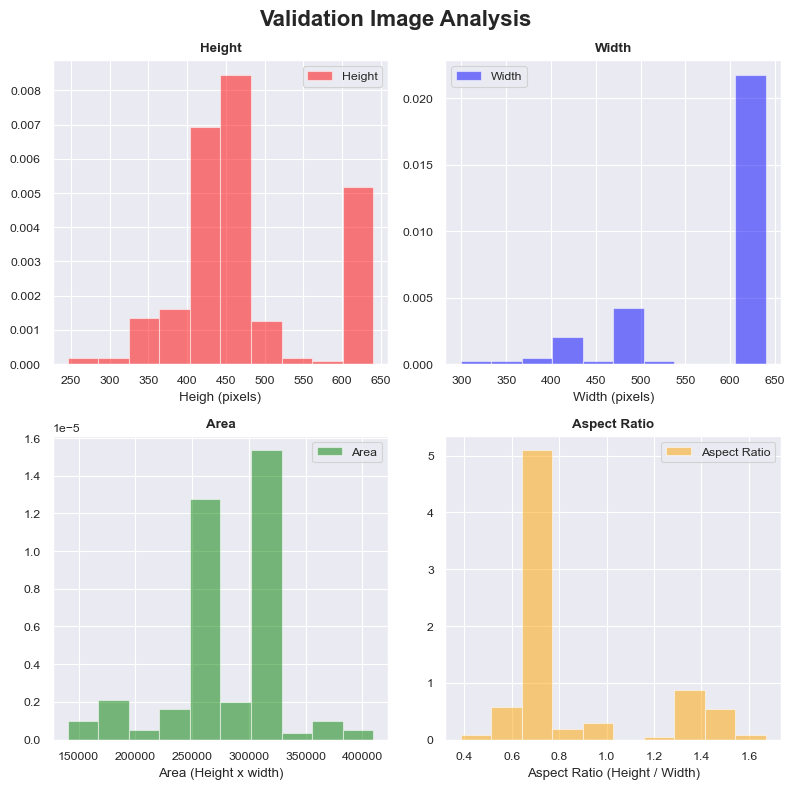

In [23]:
# validation image analysis
val_image_stats = image_analysis(val_coco, val_image_ids, "validation")

**Insights:**
- **Hieght Distribution (Top Left):** High concentration around pixel 450, with majority of the images' height between 400 and 500 pixels. A secondary pick at 600 pixel can be seen, indicating two common image iamge format. Bimodal in nature.
- **Width Distribution (Top Right):** The distribution is right skewed, with higher cluster at 600-650 pixel, meaning the validation images are wider than they are tell. Some images do have 450-500 pixel weidth.
- **Area Distribution (Bottom Left):** The distribution is bimodal, with strong concentration of images on 300000-350000 higher than training set. A secondary concentration can be seen at 250000 area.  
- **Aspect-Ratio Distribution (Bottom Right):** Heavy distribution around 0.75. Very few images are below 0.6 meaning the images are taller than they are wide in the validation. Unlike training set, validation set has no or very little number of square images.

The validation images seem to have similar image size, having height of 450 pixel and width of 650 pixel.

Plotting the Number of Images per Size Present in the Validation Set

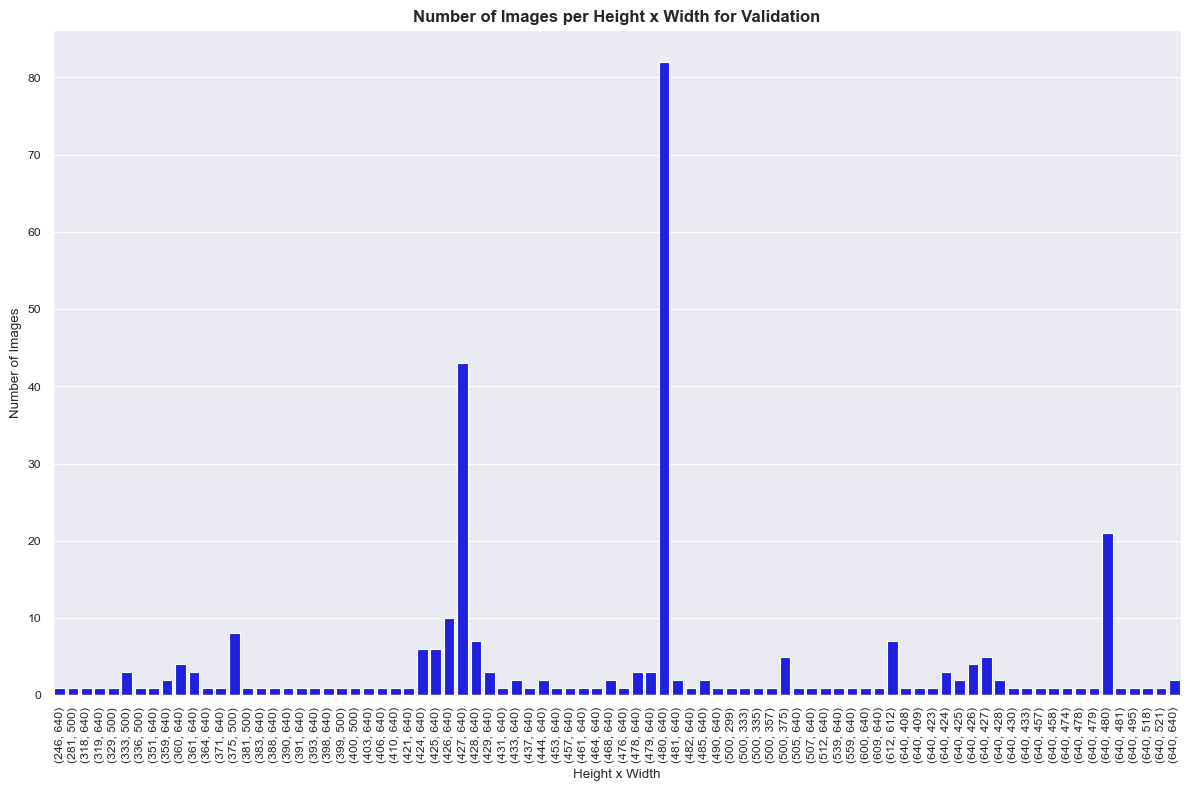

In [24]:
# number of images per hxw
val_hw_img_count = plot_img_per_height_width(val_image_stats, "validation")

As we can see the number of images with height and width of around 450 and 650 respectively are higher.

In [25]:
# looking at the stats of the training images
pd.DataFrame.from_dict(val_image_stats["stats"])

,heights,widths,areas,aspect_ratios
mean,482.850000,591.946667,281702.293333,0.851939
median,480.000000,640.000000,278400.000000,0.750000
std,88.609447,83.935752,43559.108453,0.290379
min,246.000000,299.000000,140500.000000,0.384375
max,640.000000,640.000000,409600.000000,1.672241


**Insights:**
- The majory of images have a height of around 480 and a width of around 600, same as training set.
- Validation set has shorter width and narrower height compare to training set.
- Both sets hit the same width of 640 pixels.
- In height the mean and median are very close indicating a normal distribution, same as training set.
- Aspect Ratio's mean is higher than median, indicating a right skewed, which can be seen in the right bottom of "Image Analysis Validation" graph. Few or no images are square.

### Segmentation Analysis on Training Dataset

In [ ]:
# training segmentation analysis
train_seg_analysis_result = segmentation_analysis(
    train_coco, train_image_ids, list(target_dict.keys()))

### Segmentation Analysis on Validation Dataset

In [ ]:
# validation segmentation analysis
val_seg_analysis_result = segmentation_analysis(
    val_coco, val_image_ids, list(target_dict.keys()))

In [84]:
# summarrizing the training stats
print(
    "="*70, f"\nThe Segmentatin Summary for Training Dataset:")

# display basic info
print("\nTotal Number of Annotations: ", len(
    train_seg_analysis_result["total_anns"]))
print("Total Number of Category: ", len(
    train_seg_analysis_result["category_stats"]))
print("Total Number of Super-category: ",
      len(train_seg_analysis_result["supercategory_stats"]))

print(f"\nSupercategory Distribution:")
for supercat, stats in train_seg_analysis_result["supercategory_stats"].items():
    print(f"\t{supercat}: {stats["count"]} annotations")

print("\nArea Distribution Stats:")
train_seg_analysis_result["area_dist"].groupby(
    "category_id").describe().round(2)

The Segmentatin Summary for Training Dataset:

Total Number of Annotations:  2438
Total Number of Category:  4
Total Number of Super-category:  4

Supercategory Distribution:
	person: 1350 annotations
	vehicle: 1061 annotations
	animal: 14 annotations
	food: 13 annotations

Area Distribution Stats:


id                                                     \
              count     mean      std     min     25%     50%      75%   
category_id                                                              
15             13.0  3260.00     6.87  3252.0  3255.0  3258.0  3264.00   
16           1061.0  1890.23  1145.34    11.0   859.0  1849.0  2981.00   
25             14.0  1848.21   961.47   224.0  1604.5  1725.0  2319.25   
41           1350.0  1923.46  1075.93     1.0   992.0  1961.5  2815.50   

                       area                                               \
                max   count      mean       std     min     25%      50%   
category_id                                                                
15           3272.0    13.0  12136.27  38405.53  378.35  633.41   704.25   
16           3841.0  1061.0   6768.44  23594.58   15.71  278.79   948.17   
25           3578.0    14.0  16488.84  27248.12  136.35  541.39  1712.89   
41           3870.0  1350.0  10599.04  25652.56    3.79  335.86  1172.51   

                                  
                  75%        max  
category_id                       
15            2843.19  139836.00  
16            3522.51  327730.73  
25           14737.07   82494.38  
41            6891.37  232335.04

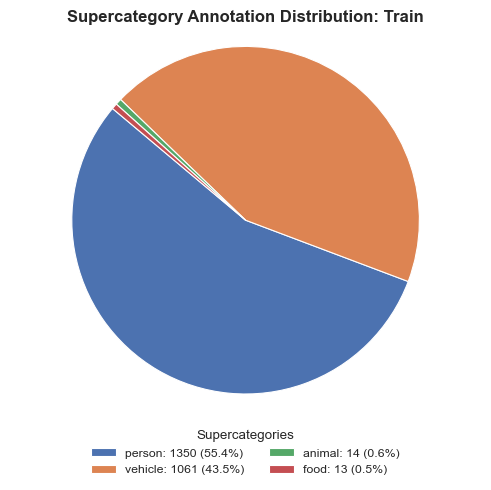

In [97]:
# Extract data from the supercategory stats
supercat_stats = train_seg_analysis_result["supercategory_stats"]
labels = list(supercat_stats.keys())
sizes = [stats["count"] for stats in supercat_stats.values()]

# Create the pie chart without labels
plt.figure(figsize=(5, 5))
wedges, _ = plt.pie(sizes, startangle=140)

# Create legend labels with percentages
total = sum(sizes)
legend_labels = [
    f"{label}: {count} ({count/total:.1%})" for label, count in zip(labels, sizes)]

# Add legend at the bottom center
plt.legend(wedges, legend_labels, title="Supercategories",
           loc="lower center", bbox_to_anchor=(0.5, -0.2),
           ncol=2, frameon=False)  # ncol adjusts columns in legend

plt.title("Supercategory Annotation Distribution: Train",
          fontsize=12, fontweight="bold")
plt.axis('equal')  # Ensure pie chart is a circle
plt.tight_layout()
plt.show()

In [98]:
# summarrizing the training stats
print(
    "="*70, f"\nThe Segmentatin Summary for Validation Dataset:")

# display basic info
print("\nTotal Number of Annotations: ", len(
    val_seg_analysis_result["total_anns"]))
print("Total Number of Category: ", len(
    val_seg_analysis_result["category_stats"]))
print("Total Number of Super-category: ",
      len(val_seg_analysis_result["supercategory_stats"]))

print(f"\nSupercategory Distribution:")
for supercat, stats in val_seg_analysis_result["supercategory_stats"].items():
    print(f"\t{supercat}: {stats["count"]} annotations")

print("\nArea Distribution Stats:")
val_seg_analysis_result["area_dist"].groupby(
    "category_id").describe().round(2)

The Segmentatin Summary for Validation Dataset:

Total Number of Annotations:  2055
Total Number of Category:  4
Total Number of Super-category:  3

Supercategory Distribution:
	vehicle: 861 annotations
	person: 1191 annotations
	food: 3 annotations

Area Distribution Stats:


id                                                      \
              count     mean      std     min      25%     50%      75%   
category_id                                                               
15            861.0  1842.37  1112.27     3.0   916.00  1812.0  2854.00   
16              1.0  1325.00      NaN  1325.0  1325.00  1325.0  1325.00   
25              2.0  3703.50     0.71  3703.0  3703.25  3703.5  3703.75   
41           1191.0  1939.86  1100.59    14.0   984.50  1996.0  2867.50   

                       area                                                    \
                max   count      mean       std       min       25%       50%   
category_id                                                                     
15           3773.0   861.0   8012.57  25860.29     16.76    321.72   1127.52   
16           1325.0     1.0  31532.41       NaN  31532.41  31532.41  31532.41   
25           3704.0     2.0   1943.83   1661.39    769.05   1356.44   1943.83   
41           3774.0  1191.0  13160.83  30274.88      8.65    416.51   1443.79   

                                  
                  75%        max  
category_id                       
15            3882.40  284574.97  
16           31532.41   31532.41  
25            2531.22    3118.61  
41            8643.94  295218.00

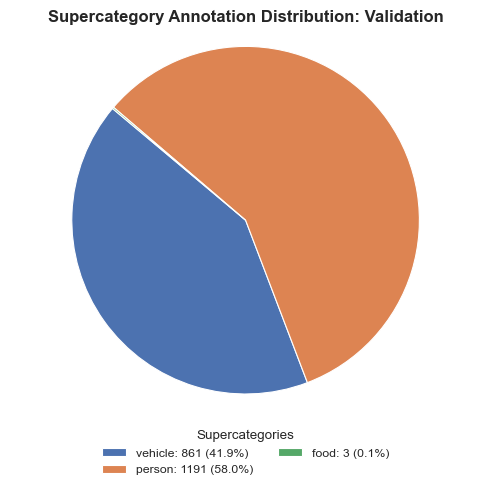

In [96]:
# Extract data from the supercategory stats
supercat_stats = val_seg_analysis_result["supercategory_stats"]
labels = list(supercat_stats.keys())
sizes = [stats["count"] for stats in supercat_stats.values()]

# Create the pie chart without labels
plt.figure(figsize=(5, 5))
wedges, _ = plt.pie(sizes, startangle=140)

# Create legend labels with percentages
total = sum(sizes)
legend_labels = [
    f"{label}: {count} ({count/total:.1%})" for label, count in zip(labels, sizes)]

# Add legend at the bottom center
plt.legend(wedges, legend_labels, title="Supercategories",
           loc="lower center", bbox_to_anchor=(0.5, -0.2),
           ncol=2, frameon=False)  # ncol adjusts columns in legend

plt.title("Supercategory Annotation Distribution: Validation",
          fontsize=12, fontweight="bold")
plt.axis('equal')  # Ensure pie chart is a circle
plt.tight_layout()
plt.show()